In [245]:
# Standard imports
import numpy as np
import pandas as pd
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.encoding import OneHotEncoder
from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.discretisation import EqualFrequencyDiscretiser

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

# Built-in library
import itertools
import re
import json
import typing as tp

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# auto reload imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
df = pd.read_csv("Cleaned_diamond_data.csv")
df1 = df.copy()
df1.head()

,Month,Manager Name,I/O,Barcode,Org Crts,ASK Purity,Final Purity,Purity group,ASK Color,Final Color,Color Group,Ask Crts,Fin Crts,Size Group,ASK P,Final Pointer,Final Value,F value,Jiram Value,Pointer Diff,Ask P Diff,Ask Size,S Purity,new_column,Diamond Price
0,Jan-23,Inhouse,Inside,222625-37.1,0.209,N4,N4,I1 & above,G,G,G-J,0.180,0.180,0.18-0.299,0.18,0.18,76.5,0.0,0.0,0.00,0.00,0.18 - 0.299,SI1 & DOWN,USA,7650.0
1,Jan-23,Inhouse,Inside,222625A-6.1,0.171,I2,I2,I1 & above,G,G,G-J,0.140,0.128,0.14-0.179,0.14,0.12,60.160000000000004,0.0,0.0,0.00,-0.02,0.14 - 0.179,SI1 & DOWN,Belgium,4800
2,Jan-23,Inhouse,Inside,222645-607,0.173,I2-,I2-,I1 & above,G,H,G-J,0.142,0.132,0.14-0.179,0.14,0.13,49.5,0.0,0.0,-0.01,-0.01,0.14 - 0.179,SI1 & DOWN,Belgium,5395.999999999999
3,Jan-23,Inhouse,Inside,222665-486,0.625,N2,N2,I1 & above,I,I,G-J,0.489,0.465,0.3 & up,0.48,0.46,627.75,0.0,0.0,-0.02,-0.02,0.3 & Up,SI1 & DOWN,UAE,66015.0
4,Jan-23,Diamcor Mining,Outside,227530-1-01,0.006,VS2,VS1,VS1-VS2,G,H,G-J,0.005,0.005,0.019 & below,0.00,0.00,2.725,0.0,0.0,0.00,0.00,0 - 0.019,IF TO VS2,Hong Kong,252.5


In [247]:
df1.info(), df1.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577046 entries, 0 to 577045
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Month          577046 non-null  object 
 1   Manager Name   577046 non-null  object 
 2   I/O            577046 non-null  object 
 3   Barcode        577046 non-null  object 
 4   Org Crts       577046 non-null  float64
 5   ASK Purity     577046 non-null  object 
 6   Final Purity   577046 non-null  object 
 7   Purity group   577046 non-null  object 
 8   ASK Color      577046 non-null  object 
 9   Final Color    577046 non-null  object 
 10  Color Group    577046 non-null  object 
 11  Ask Crts       577046 non-null  float64
 12  Fin Crts       577046 non-null  float64
 13  Size Group     577046 non-null  object 
 14  ASK P          577046 non-null  float64
 15  Final Pointer  577046 non-null  float64
 16  Final Value    577046 non-null  object 
 17  F value        577046 non-nul

(None, (577046, 25))

## Feature Selection

* ### Check the Correlation of Features

* Subsets of features are evaluated by correlation feature selection based on the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

```
References:
M. Hal, Correlation-based Feature Selection for Machine Learning
```

In [248]:
def get_correlated_features(*, data: pd.DataFrame, threshold: float) -> list:
    """This is used to return a list of highly correlated features."""
    # Select only numeric data
    num_data = data.select_dtypes(include=[int, float])

    # Store the correlated columns
    col_corr = set()

    # Correlation matrix
    corr_matrix = num_data.corr()

    for i in range(len(corr_matrix.columns)):

        # check with other features
        for j in range(i):

            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:

                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(
                    f"correlation: {abs(corr_matrix.iloc[i, j])}, "
                    f"feature 1:{corr_matrix.columns[i]}, feature 2:{corr_matrix.columns[j]}"
                )

                # Get the name of the correlated feature
                col_name = corr_matrix.columns[j]

                # and add it to our correlated set
                col_corr.add(col_name)

    return list(col_corr)

In [249]:
get_correlated_features(data=df1, threshold=0.75)

correlation: 0.9675600194262971, feature 1:Ask Crts, feature 2:Org Crts
correlation: 0.9676063652731725, feature 1:Fin Crts, feature 2:Org Crts
correlation: 0.9974915919789737, feature 1:Fin Crts, feature 2:Ask Crts
correlation: 0.9661684805293962, feature 1:ASK P, feature 2:Org Crts
correlation: 0.9990581116891716, feature 1:ASK P, feature 2:Ask Crts
correlation: 0.9967614246963487, feature 1:ASK P, feature 2:Fin Crts
correlation: 0.9653018813126741, feature 1:Final Pointer, feature 2:Org Crts
correlation: 0.9954229754644264, feature 1:Final Pointer, feature 2:Ask Crts
correlation: 0.9981475586667286, feature 1:Final Pointer, feature 2:Fin Crts
correlation: 0.9950028049316185, feature 1:Final Pointer, feature 2:ASK P
correlation: 1.0, feature 1:Jiram Value, feature 2:F value


['Ask Crts', 'F value', 'ASK P', 'Fin Crts', 'Org Crts']

In [250]:
df1 = df1.drop(columns=['Ask Crts', 'F value', 'ASK P', 'Fin Crts', 'Org Crts'])

In [251]:
df1.shape

(577046, 20)

###  Mutual information

* Using mutual information, we can measure how much uncertainty is reduced in variable A when we know variable B. 
* To select variables, we are interested in the mutual information between the predictor variables and the target. 
* Higher mutual information values, indicate little uncertainty about the target Y given the predictor X.

In [252]:
df1["Diamond Price"].unique(), df1["Diamond Price"].nunique()

(array(['7650.0', '4800', '5395.999999999999', ..., '646.0000000000001',
        '788.5', '747.0'], dtype=object),
 10391)

In [253]:
df1["Diamond Price"] = pd.to_numeric(df1["Diamond Price"], errors='coerce')
df1["Diamond Price"].isna().sum()

4080

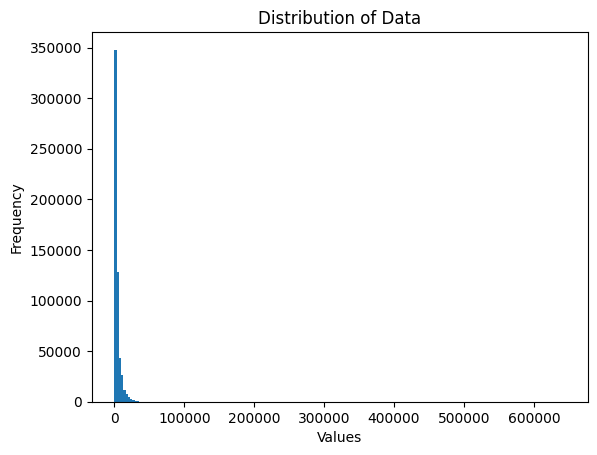

In [254]:
plt.hist(df2["Diamond Price"], bins=200)  # Adjust the number of bins as needed
plt.title('Distribution of Data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [255]:
df1["Diamond Price"] = df1["Diamond Price"].fillna(df1['Diamond Price'].median())

In [256]:
df1["Final Value"] = pd.to_numeric(df1["Final Value"], errors='coerce')
df1["Final Value"].isna().sum()

353

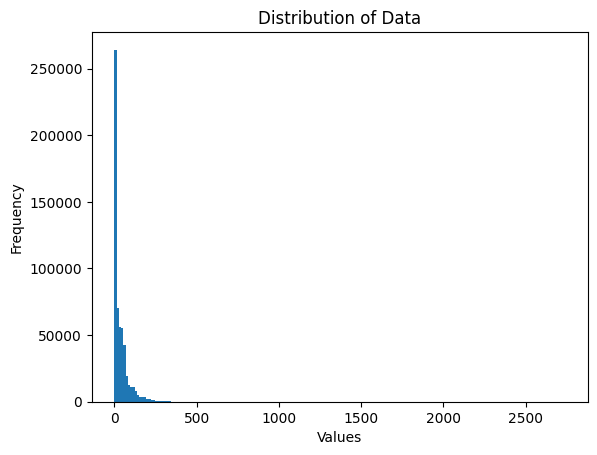

In [257]:
plt.hist(df1["Final Value"], bins=200)  # Adjust the number of bins as needed
plt.title('Distribution of Data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [258]:
df1["Final Value"] = df1["Final Value"].fillna(df1['Final Value'].median())

In [259]:
# Mutual information values
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.linear_model import LogisticRegression


RANDOM_STATE = 123
TEST_SIZE = 0.2
TARGET = "Diamond Price"

In [260]:
df2 = df1.copy()
X = df2.drop(columns=[TARGET])
y = df2[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((461636, 19), (115410, 19), (461636,), (115410,))

In [261]:
y_train2 = pd.DataFrame(y_train)
y_train2

# Splitting the trainset into categorical and numerical data, to check mutual information
x_num_variables = X_train.select_dtypes(exclude='object')
y_num_variables = y_train2.select_dtypes(exclude='object')
x_num_variables.shape, y_num_variables.shape

((461636, 5), (461636, 1))

In [262]:
# Calculate the mutual information between the variables and the target
# Note: The lower the mi value, the less can be inferred about the target from the feature.

# You should consider scaling the features

MI = mutual_info_regression(x_num_variables, y_train, random_state=RANDOM_STATE)
MI

array([1.96127184, 3.71670599, 0.0059816 , 0.17408418, 0.14674132])

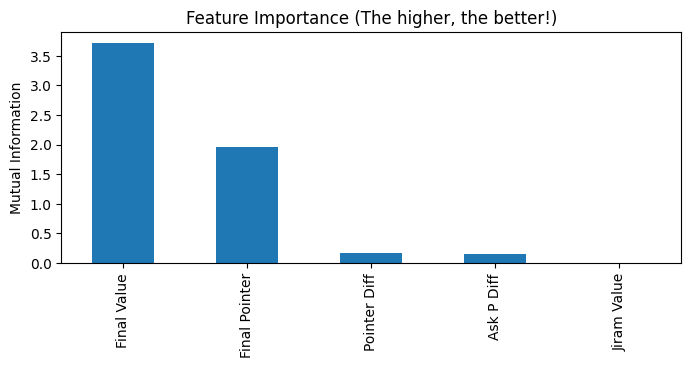

In [263]:
# Visualize The Feature Importance

feat_importance = pd.Series(MI)
feat_importance.index = x_num_variables.columns
feat_importance.sort_values(ascending=False).plot(
    kind="bar",
    ylabel="Mutual Information",
    title="Feature Importance (The higher, the better!)",
    figsize=(8, 3),
)
plt.show()

Due to the fact that higher is better, I will drop the last feature(Jiram Value) with very low mutual information

In [264]:
df1 = df1.drop(columns=["Jiram Value"])
df1.head(4)

,Month,Manager Name,I/O,Barcode,ASK Purity,Final Purity,Purity group,ASK Color,Final Color,Color Group,Size Group,Final Pointer,Final Value,Pointer Diff,Ask P Diff,Ask Size,S Purity,new_column,Diamond Price
0,Jan-23,Inhouse,Inside,222625-37.1,N4,N4,I1 & above,G,G,G-J,0.18-0.299,0.18,76.50,0.00,0.00,0.18 - 0.299,SI1 & DOWN,USA,7650.0
1,Jan-23,Inhouse,Inside,222625A-6.1,I2,I2,I1 & above,G,G,G-J,0.14-0.179,0.12,60.16,0.00,-0.02,0.14 - 0.179,SI1 & DOWN,Belgium,4800.0
2,Jan-23,Inhouse,Inside,222645-607,I2-,I2-,I1 & above,G,H,G-J,0.14-0.179,0.13,49.50,-0.01,-0.01,0.14 - 0.179,SI1 & DOWN,Belgium,5396.0
3,Jan-23,Inhouse,Inside,222665-486,N2,N2,I1 & above,I,I,G-J,0.3 & up,0.46,627.75,-0.02,-0.02,0.3 & Up,SI1 & DOWN,UAE,66015.0


From domain knowledge drop columns that have no contrbution to diamond price

In [265]:
df1 = df1.drop(columns=["Month", "Barcode"])
df1.head(4)

,Manager Name,I/O,ASK Purity,Final Purity,Purity group,ASK Color,Final Color,Color Group,Size Group,Final Pointer,Final Value,Pointer Diff,Ask P Diff,Ask Size,S Purity,new_column,Diamond Price
0,Inhouse,Inside,N4,N4,I1 & above,G,G,G-J,0.18-0.299,0.18,76.50,0.00,0.00,0.18 - 0.299,SI1 & DOWN,USA,7650.0
1,Inhouse,Inside,I2,I2,I1 & above,G,G,G-J,0.14-0.179,0.12,60.16,0.00,-0.02,0.14 - 0.179,SI1 & DOWN,Belgium,4800.0
2,Inhouse,Inside,I2-,I2-,I1 & above,G,H,G-J,0.14-0.179,0.13,49.50,-0.01,-0.01,0.14 - 0.179,SI1 & DOWN,Belgium,5396.0
3,Inhouse,Inside,N2,N2,I1 & above,I,I,G-J,0.3 & up,0.46,627.75,-0.02,-0.02,0.3 & Up,SI1 & DOWN,UAE,66015.0


### Rename the colunms

In [266]:
df1.columns

Index(['Manager Name', 'I/O', 'ASK Purity', 'Final Purity', 'Purity group',
       'ASK Color', 'Final Color', 'Color Group', 'Size Group',
       'Final Pointer', 'Final Value', 'Pointer Diff', 'Ask P Diff',
       'Ask Size', 'S Purity', 'new_column', 'Diamond Price'],
      dtype='object')

In [267]:
# df1.rename(columns = {'term':'Loan Term',
#                       'verification_status':'Verification by Loan Company',                                        
#                       'purpose':'Loan Purpose', 
#                       'application_type':'Application Type', 
#                       'emp_length':'Total Years of Employment', 
#                       'annual_inc':'Annual Income',
#                       'mort_acc':'No of Mortgage Account',
#                       'loan_status':'Loan Status',
#                       'dti':'Income-Debt Ratio',
#                       'open_acc':'No of Open Credit Lines',
#                       'revol_util':'Credit Utilization Rate'}, 
#                       inplace = True)

### Pipeline for Feature Engineering

In [268]:
df2 = df1.copy()
df2.head()

,Manager Name,I/O,ASK Purity,Final Purity,Purity group,ASK Color,Final Color,Color Group,Size Group,Final Pointer,Final Value,Pointer Diff,Ask P Diff,Ask Size,S Purity,new_column,Diamond Price
0,Inhouse,Inside,N4,N4,I1 & above,G,G,G-J,0.18-0.299,0.18,76.500,0.00,0.00,0.18 - 0.299,SI1 & DOWN,USA,7650.0
1,Inhouse,Inside,I2,I2,I1 & above,G,G,G-J,0.14-0.179,0.12,60.160,0.00,-0.02,0.14 - 0.179,SI1 & DOWN,Belgium,4800.0
2,Inhouse,Inside,I2-,I2-,I1 & above,G,H,G-J,0.14-0.179,0.13,49.500,-0.01,-0.01,0.14 - 0.179,SI1 & DOWN,Belgium,5396.0
3,Inhouse,Inside,N2,N2,I1 & above,I,I,G-J,0.3 & up,0.46,627.750,-0.02,-0.02,0.3 & Up,SI1 & DOWN,UAE,66015.0
4,Diamcor Mining,Outside,VS2,VS1,VS1-VS2,G,H,G-J,0.019 & below,0.00,2.725,0.00,0.00,0 - 0.019,IF TO VS2,Hong Kong,252.5


In [269]:
TARGET = "Diamond Price"
RANDOM_STATE = 123
TEST_SIZE = 0.2

# Split the data into features (x) and the target variable (y)
x = df2.drop(columns=TARGET)
y = df2[TARGET]

# Split the data
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


In [270]:
df2.columns

Index(['Manager Name', 'I/O', 'ASK Purity', 'Final Purity', 'Purity group',
       'ASK Color', 'Final Color', 'Color Group', 'Size Group',
       'Final Pointer', 'Final Value', 'Pointer Diff', 'Ask P Diff',
       'Ask Size', 'S Purity', 'new_column', 'Diamond Price'],
      dtype='object')

In [271]:
df2["ASK Purity"].unique(), df2["ASK Purity"].nunique()  ##OHE

(array(['N4', 'I2', 'I2-', 'N2', 'VS2', 'VS1', 'VVS2', 'I1', 'SI2', 'I1-',
        'SI3', 'N3', 'SI1', 'VVS1', 'I3', 'SI3-', 'N5', 'N6', 'I3-', 'I1 ',
        'I4', 'I1 +', 'N7', 'I2+'], dtype=object),
 24)

In [272]:
df2["Final Purity"].unique(), df2["Final Purity"].nunique() #OHE

(array(['N4', 'I2', 'I2-', 'N2', 'VS1', 'SI1', 'I1', 'VVS2', 'SI2', 'I1-',
        'VS2', 'SI3', 'N3', 'N5', 'N6', 'VVS1', 'I3', 'I3-', 'I4', 'SI3-',
        'N7', 'I5', 'I1 +', 'I2+'], dtype=object),
 24)

In [273]:
df2["Purity group"].unique(), df2["Purity group"].nunique() #OHE

(array(['I1 & above', 'VS1-VS2', 'VVS1-VVS2', 'SI1-SI3'], dtype=object), 4)

In [274]:
df2["ASK Color"].unique(), df2["ASK Color"].nunique() #OHE

(array(['G', 'I', 'H', 'J', 'F', 'K', 'L', 'E', 'D', 'M', 'N', 'H-', 'G+',
        'I-', 'H+', 'O', 'D-', 'E+', 'D+', 'I+', 'R'], dtype=object),
 21)

In [275]:
df2["Final Color"].unique(), df2["Final Color"].nunique() #OHE

(array(['G', 'H', 'I', 'F', 'J', 'K', 'M', 'L', 'D', 'E', 'O', 'G+', 'N',
        'D-', 'V', 'J+', 'R'], dtype=object),
 17)

In [276]:
df2["Color Group"].unique(), df2["Size Group"].unique() #OHE

(array(['G-J', 'D-F', 'K-M', 'N-R'], dtype=object),
 array(['0.18-0.299', '0.14-0.179', '0.3 & up', '0.019 & below',
        '0.05-0.079', '0.02-0.049', '0.08-0.139'], dtype=object))

In [277]:

df2["Color Group"].unique(), df2["Size Group"].unique() #OHE

(array(['G-J', 'D-F', 'K-M', 'N-R'], dtype=object),
 array(['0.18-0.299', '0.14-0.179', '0.3 & up', '0.019 & below',
        '0.05-0.079', '0.02-0.049', '0.08-0.139'], dtype=object))

In [278]:
df2["Final Pointer"].unique(), df2["Final Pointer"].nunique() 

(array([1.80e-01, 1.20e-01, 1.30e-01, 4.60e-01, 0.00e+00, 1.00e-02,
        1.60e-01, 4.00e-02, 3.00e-02, 2.30e-01, 1.40e-01, 1.90e-01,
        5.00e-02, 9.00e-02, 2.10e-01, 7.00e-02, 6.00e-02, 2.00e-02,
        2.50e-01, 2.70e-01, 1.50e-01, 1.00e-01, 2.00e-01, 1.10e-01,
        8.00e-02, 2.60e-01, 2.40e-01, 2.80e-01, 3.00e-01, 2.20e-01,
        1.70e-01, 2.90e-01, 3.10e-01, 5.00e-01, 3.20e-01, 4.20e-01,
        3.80e-01, 5.20e-01, 3.90e-01, 3.70e-01, 5.10e-01, 5.30e-01,
        7.60e-01, 4.90e-01, 4.30e-01, 3.60e-01, 4.10e-01, 4.40e-01,
        3.40e-01, 4.00e-01, 5.40e-01, 7.20e-01, 5.50e-01, 4.70e-01,
        5.70e-01, 3.30e-01, 4.80e-01, 5.60e-01, 3.50e-01, 7.30e-01,
        7.00e-01, 6.20e-01, 7.50e-01, 7.10e-01, 6.30e-01, 8.00e-01,
        6.00e-01, 8.20e-01, 4.50e-01, 6.50e-01, 6.40e-01, 7.40e-01,
        9.30e-01, 5.80e-01, 6.10e-01, 6.60e-01, 8.90e-01, 6.70e-01,
        8.10e-01, 7.70e-01, 5.90e-01, 1.02e+00, 1.00e+00, 1.21e+00,
        6.80e-01, 8.30e-01, 9.40e-01, 9.20e-01, 

In [279]:
df2["Final Value"].unique(), df2["Final Value"].nunique() # discretize

(array([ 76.5  ,  60.16 ,  49.5  , ...,  14.835, 143.325,   6.64 ]), 11946)

In [280]:
df2["Pointer Diff"].unique(), df2["Pointer Diff"].nunique() 

(array([ 0.0000000e+00, -1.0000000e-02, -2.0000000e-02,  1.0000000e-02,
         1.0000000e-02, -1.0000000e-02,  2.0000000e-02, -2.0000000e-02,
         2.0000000e-02, -1.1000000e-01, -2.0000000e-01, -3.0000000e-02,
        -3.2699992e-03,  3.0000000e-02, -6.0000000e-02, -8.0000000e-02,
         4.0000000e-02, -9.0000000e-02,  3.0000000e-02,  4.0000000e-02,
        -4.0000000e-02, -7.0000000e-02,  5.0000000e-02,  1.0000000e-01,
         6.0000000e-02,  5.0000000e-02,  1.4000000e-01,  8.0000000e-02,
         1.1000000e-01, -1.9000000e-01, -1.0000000e-01, -1.6000000e-01,
        -2.7000000e-01, -3.0000000e-02, -5.0000000e-02,  1.0000000e-02,
        -1.1000000e-01, -1.0000000e-02,  6.0000000e-02, -9.0000000e-02,
        -1.4000000e-01, -4.9000000e-01,  6.0000000e-02, -2.9000000e-01,
        -4.0000000e-02, -5.0000000e-02,  1.1000000e-01, -3.1000000e-01,
        -4.5000000e-01,  1.2000000e-01, -7.0000000e-02, -2.4000000e-01,
         7.0000000e-02,  8.0000000e-02, -1.3000000e-01,  1.70000

In [281]:
df2["Ask P Diff"].unique(), df2["Ask P Diff"].nunique() 

(array([ 0.       , -0.02     , -0.01     , -0.02     , -0.01     ,
         0.01     ,  0.01     ,  0.02     ,  0.02     , -0.11     ,
        -0.2      , -0.03     , -0.0041288,  0.05     ,  0.03     ,
         0.09     , -0.04     , -0.05     , -0.06     , -0.08     ,
         0.04     , -0.09     ,  0.03     ,  0.04     , -0.05     ,
        -0.07     ,  0.05     ,  0.06     ,  0.07     , -0.19     ,
        -0.1      , -0.16     , -0.04     , -0.03     ,  0.01     ,
         0.08     ,  0.08     , -0.11     , -0.07     , -0.88     ,
        -0.27     , -0.01     ,  0.1      ,  0.06     , -0.09     ,
        -0.14     , -0.49     ,  0.06     , -0.29     , -0.08     ,
         0.1      , -0.1      ,  0.11     , -0.31     , -0.45     ,
         0.12     , -0.24     , -0.13     , -0.12     ,  0.13     ,
        -0.14     , -0.25     , -0.009    , -0.029    , -0.019    ,
        -0.21     , -0.17     , -0.15     ,  0.07     ,  0.67     ,
        -0.06     ,  0.26     , -0.3      ,  0.1

In [282]:
df2["Ask Size"].unique(), df2["Ask Size"].nunique() 

(array(['0.18 - 0.299', '0.14 - 0.179', '0.3 & Up', '0 - 0.019',
        '0.05 - 0.079', '0.02 - 0.049', '0.08 - 0.139'], dtype=object),
 7)

In [283]:
df2["S Purity"].unique(), df2["S Purity"].nunique() #OHE

(array(['SI1 & DOWN', 'IF TO VS2', '0'], dtype=object), 3)

In [284]:
df2["new_column"].unique(), df2["new_column"].nunique() #OHE

(array(['USA', 'Belgium', 'UAE', 'Hong Kong', 'Japan', 'Australia',
        'India'], dtype=object),
 7)

In [285]:
columns_to_dicretize = ["Final Value"]
columns_to_encode = ['Manager Name', 'I/O', 'ASK Purity', 'Final Purity', 'Purity group', 'ASK Color', 'Final Color', 'Color Group',
                     'Size Group', 'Ask Size', 'S Purity', 'new_column'] 

In [286]:
feat_eng_pipe = Pipeline(
    steps=[
 
        # ========== DISCRETIZE NUMERICAL VARIABLES ==========
        (
            "discretizer",
            EqualFrequencyDiscretiser(
                variables=columns_to_dicretize,
                q=10,
            ),
        ),

        # ========== ENCODE CATEGORICAL VARIABLES ==========
        (
            "OneHotEncoder",
            OneHotEncoder(top_categories=None, drop_last=True,  
            variables=columns_to_encode, ignore_format=False),
        ),
        # ========== SCALE NUMERICAL VARIABLES ==========
        (
            "scaler",
            StandardScaler()
        ),
    ],
)

feat_eng_pipe

Pipeline(steps=[('discretizer',
                 EqualFrequencyDiscretiser(variables=['Final Value'])),
                ('OneHotEncoder',
                 OneHotEncoder(drop_last=True,
                               variables=['Manager Name', 'I/O', 'ASK Purity',
                                          'Final Purity', 'Purity group',
                                          'ASK Color', 'Final Color',
                                          'Color Group', 'Size Group',
                                          'Ask Size', 'S Purity',
                                          'new_column'])),
                ('scaler', StandardScaler())])

In [287]:
# Train the pipeline
features = feat_eng_pipe.fit(x_train, y_train)

# MODEL BUILDING

In [288]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

### LINEAR REGRESSION MODEL

In [289]:
#initialize LinearRegression
LR = LinearRegression()

pipe_LinearRegression = Pipeline(
    steps=[
        # ===== feat_eng_pipe =====
        ("feat_eng_pipe", feat_eng_pipe),
        # ===== xgboostmodel Model =====
        ("LinearRegression", LR),
    ]
)

pipe_LinearRegression

Pipeline(steps=[('feat_eng_pipe',
                 Pipeline(steps=[('discretizer',
                                  EqualFrequencyDiscretiser(variables=['Final '
                                                                       'Value'])),
                                 ('OneHotEncoder',
                                  OneHotEncoder(drop_last=True,
                                                variables=['Manager Name',
                                                           'I/O', 'ASK Purity',
                                                           'Final Purity',
                                                           'Purity group',
                                                           'ASK Color',
                                                           'Final Color',
                                                           'Color Group',
                                                           'Size Group',
                                                           'Ask Size',
                                                           'S Purity',
                                                           'new_column'])),
                                 ('scaler', StandardScaler())])),
                ('LinearRegression', LinearRegression())])

In [290]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [291]:
# Fit
pipe_LinearRegression.fit(x_train, y_train)

# Make predictions
y_pred_1 = pipe_LinearRegression.predict(x_test)
y_pred_1

array([ 1352.98847977, -1463.25585923,  4659.48876968, ...,
        1936.40092852,  9798.86615367,  -517.16461256])

In [292]:
print('R squared of the Linear Regression on training set: {:.2%}'.format(pipe_LinearRegression.score(x_train, y_train)))
print('R squared of the Linear Regression on test set: {:.2%}'.format(pipe_LinearRegression.score(x_test, y_test)))

R squared of the Linear Regression on training set: 88.26%
R squared of the Linear Regression on test set: -20845981169189711872.00%


### DECISION TREE MODEL

In [293]:
import sklearn.tree as st

#initialize DecisionTree
DT = st.DecisionTreeRegressor(random_state=42)
pipe_DecisionTree = Pipeline(
    steps=[
        # ===== feat_eng_pipe =====
        ("feat_eng_pipe", feat_eng_pipe),
        # ===== xgboostmodel Model =====
        ("DecisionTree",DT),
    ]
)

pipe_DecisionTree

Pipeline(steps=[('feat_eng_pipe',
                 Pipeline(steps=[('discretizer',
                                  EqualFrequencyDiscretiser(variables=['Final '
                                                                       'Value'])),
                                 ('OneHotEncoder',
                                  OneHotEncoder(drop_last=True,
                                                variables=['Manager Name',
                                                           'I/O', 'ASK Purity',
                                                           'Final Purity',
                                                           'Purity group',
                                                           'ASK Color',
                                                           'Final Color',
                                                           'Color Group',
                                                           'Size Group',
                                                           'Ask Size',
                                                           'S Purity',
                                                           'new_column'])),
                                 ('scaler', StandardScaler())])),
                ('DecisionTree', DecisionTreeRegressor(random_state=42))])

In [294]:
# Fit
pipe_DecisionTree.fit(x_train, y_train)

# Make predictions
y_pred_2 = pipe_DecisionTree.predict(x_test)
y_pred_2

array([ 357.23333333,  530.        , 4781.0625    , ..., 1260.        ,
       8280.        ,  281.25      ])

In [295]:
print('R squared of the Decision Tree Regressor on training set: {:.2%}'.format(pipe_DecisionTree.score(x_train, y_train)))
print('R squared of the Decision Tree Regressor on test set: {:.2%}'.format(pipe_DecisionTree.score(x_test, y_test)))

R squared of the Decision Tree Regressor on training set: 97.70%
R squared of the Decision Tree Regressor on test set: 98.08%


### RANDOM FOREST REGRESSOR MODEL

In [297]:
#initialize Random Forest Model
RF = RandomForestRegressor(n_estimators=100, random_state=42)
pipe_RandomForest = Pipeline(
    steps=[
        # ===== feat_eng_pipe =====
        ("feat_eng_pipe", feat_eng_pipe),
        # ===== Random Forest Model Model =====
        ("RandomForest",RF),
    ]
)

pipe_RandomForest

Pipeline(steps=[('feat_eng_pipe',
                 Pipeline(steps=[('discretizer',
                                  EqualFrequencyDiscretiser(variables=['Final '
                                                                       'Value'])),
                                 ('OneHotEncoder',
                                  OneHotEncoder(drop_last=True,
                                                variables=['Manager Name',
                                                           'I/O', 'ASK Purity',
                                                           'Final Purity',
                                                           'Purity group',
                                                           'ASK Color',
                                                           'Final Color',
                                                           'Color Group',
                                                           'Size Group',
                                                           'Ask Size',
                                                           'S Purity',
                                                           'new_column'])),
                                 ('scaler', StandardScaler())])),
                ('RandomForest', RandomForestRegressor(random_state=42))])

In [298]:
# Fit
pipe_RandomForest.fit(x_train, y_train)

# Make predictions
y_pred_3 = pipe_RandomForest.predict(x_test)
y_pred_3

array([ 358.33147239,  543.28380952, 4786.33777539, ..., 1260.2625    ,
       8242.84      ,  281.14678482])

In [299]:
print('R squared of the Random Forest Regressor on training set: {:.2%}'.format(pipe_RandomForest.score(x_train, y_train)))
print('R squared of the Random Forest Regressor on test set: {:.2%}'.format(pipe_RandomForest.score(x_test, y_test)))

R squared of the Random Forest Regressor on training set: 97.41%
R squared of the Random Forest Regressor on test set: 98.90%


### RIDGE MODEL

In [300]:
#initialize Ridge model
ridge = Ridge(alpha=1.0, random_state=42)
pipe_Ridge = Pipeline(
    steps=[
        # ===== feat_eng_pipe =====
        ("feat_eng_pipe", feat_eng_pipe),
        # ===== Ridge Model =====
        ("Ridge",ridge),
    ]
)

pipe_Ridge

Pipeline(steps=[('feat_eng_pipe',
                 Pipeline(steps=[('discretizer',
                                  EqualFrequencyDiscretiser(variables=['Final '
                                                                       'Value'])),
                                 ('OneHotEncoder',
                                  OneHotEncoder(drop_last=True,
                                                variables=['Manager Name',
                                                           'I/O', 'ASK Purity',
                                                           'Final Purity',
                                                           'Purity group',
                                                           'ASK Color',
                                                           'Final Color',
                                                           'Color Group',
                                                           'Size Group',
                                                           'Ask Size',
                                                           'S Purity',
                                                           'new_column'])),
                                 ('scaler', StandardScaler())])),
                ('Ridge', Ridge(random_state=42))])

In [301]:
# Fit
pipe_Ridge.fit(x_train, y_train)

# Make predictions
y_pred_4 = pipe_Ridge.predict(x_test)
y_pred_4

array([ 1352.68427868, -1463.71653901,  4662.39763104, ...,
        1937.77519651,  9797.4620093 ,  -516.6426281 ])

In [302]:
print('R squared of the Ridge Regressor on training set: {:.2%}'.format(pipe_Ridge.score(x_train, y_train)))
print('R squared of the Ridge Regressor on test set: {:.2%}'.format(pipe_Ridge.score(x_test, y_test)))

R squared of the Ridge Regressor on training set: 88.26%
R squared of the Ridge Regressor on test set: 90.94%


### LASSO MODEL

In [305]:
#initialize Ridge model
lasso = Lasso(alpha=1.0, max_iter=10000, random_state=42)
pipe_Lasso = Pipeline(
    steps=[
        # ===== feat_eng_pipe =====
        ("feat_eng_pipe", feat_eng_pipe),
        # ===== Lasso Model =====
        ("Ridge",lasso),
    ]
)

pipe_Lasso

Pipeline(steps=[('feat_eng_pipe',
                 Pipeline(steps=[('discretizer',
                                  EqualFrequencyDiscretiser(variables=['Final '
                                                                       'Value'])),
                                 ('OneHotEncoder',
                                  OneHotEncoder(drop_last=True,
                                                variables=['Manager Name',
                                                           'I/O', 'ASK Purity',
                                                           'Final Purity',
                                                           'Purity group',
                                                           'ASK Color',
                                                           'Final Color',
                                                           'Color Group',
                                                           'Size Group',
                                                           'Ask Size',
                                                           'S Purity',
                                                           'new_column'])),
                                 ('scaler', StandardScaler())])),
                ('Ridge', Lasso(max_iter=10000, random_state=42))])

In [306]:
# Fit
pipe_Lasso.fit(x_train, y_train)

# Make predictions
y_pred_5 = pipe_Lasso.predict(x_test)
y_pred_5

array([ 1342.5331516 , -1456.39753109,  4663.76604078, ...,
        1929.3812842 ,  9829.99828948,  -496.81316558])

In [307]:
print('R squared of the Lasso Regressor on training set: {:.2%}'.format(pipe_Lasso.score(x_train, y_train)))
print('R squared of the Lasso Regressor on test set: {:.2%}'.format(pipe_Lasso.score(x_test, y_test)))

R squared of the Lasso Regressor on training set: 88.24%
R squared of the Lasso Regressor on test set: 90.94%


# MODEL EVALUATION

In [308]:
print('Mean Absolute Error of the Linear Regression on test set is {:.2f}'.format(metrics.mean_absolute_error(y_test,y_pred_1)))

Mean Absolute Error of the Linear Regression on test set is 7498478987.14


In [309]:
print('Mean Absolute Error of the Decision Tree Regressor on test set is {:.2f}'.format(metrics.mean_absolute_error(y_test,y_pred_2)))

Mean Absolute Error of the Decision Tree Regressor on test set is 180.51


In [310]:
print('Mean Absolute Error of the Random Forest Regressor on test set is {:.2f}'.format(metrics.mean_absolute_error(y_test,y_pred_3)))

Mean Absolute Error of the Random Forest Regressor on test set is 163.88


In [311]:
print('Mean Absolute Error of the Ridge Regressor on test set is {:.2f}'.format(metrics.mean_absolute_error(y_test,y_pred_4)))

Mean Absolute Error of the Ridge Regressor on test set is 731.30


In [312]:
print('Mean Absolute Error of the Lasso Regressor on test set is {:.2f}'.format(metrics.mean_absolute_error(y_test,y_pred_5)))

Mean Absolute Error of the Lasso Regressor on test set is 723.44
